In [2]:
import os
import pandas as pd
from urllib.parse import parse_qs
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [11]:
url = "output_file_0=output_dynamic_libraries.csv&output_file_1=output_baseline_libraries.csv&output_file_2=output_baseline_cedar.csv&output_file_3=output_dynamic_cedar.csv&output_file_4=output_baseline_DafnyVMC.csv&output_file_5=output_dynamic_DafnyVMC.csv"
url2 = "output_file_0=.%2Fresults_llm%2Foutput_static_libraries.csv&output_file_1=.%2Fresults_llm%2Foutput_placeholder_libraries.csv&output_file_2=.%2Fresults_llm%2Foutput_placeholder_cedar.csv&output_file_3=.%2Fresults_llm%2Foutput_static_cedar.csv&output_file_4=.%2Fresults_llm%2Foutput_placeholder_DafnyVMC.csv&output_file_5=.%2Fresults_llm%2Foutput_dynamic_DafnyVMC.csv&output_file_6=.%2Fresults_llm%2Foutput_static_DafnyVMC.csv"
RESULT_PATH = "../results_llm/"

# Main evaluation dashboard

In [4]:
# parse the url
parsed2 = parse_qs(url2)
parsed = parse_qs(url)

In [5]:
def get_type_output_file(filename):
    type_analysis = filename.split("_")[1]
    return type_analysis


def get_benchmarck_name(filename):
    type_analysis = filename.split("_")[2].split(".")[0]
    return type_analysis


def get_ouput_files(dir):
    """
    Return all the filenames in the directory that start by output_
    """
    files = os.listdir(dir)
    output_files = [f for f in files if f.startswith("output_")]
    k_files = [f for f in output_files if "basic" in f]
    return k_files
    # return output_files

In [12]:
results = {}
# for el, file_list in parsed.items():
print(os.getcwd())
for filename in get_ouput_files(RESULT_PATH):
    type_analysis = get_type_output_file(filename)
    benchmark_name = get_benchmarck_name(filename)
    print(filename)
    df = pd.read_csv(RESULT_PATH + filename)
    results[(type_analysis, benchmark_name)] = df
    # print(f"Type analysis: {type_analysis}, Benchmark: {benchmark_name}")
    # display(df["New Method Result"].value_counts())

/usr/local/home/eric/dafny_repair/notebooks
output_placeholder_libraries-basic.csv
output_placeholder_vmc-basic.csv
output_baseline_cedar-basic.csv
output_error_libraries-basic.csv
output_error_cedar-basic.csv
output_errorplaceholder_cedar-basic.csv
output_placeholder_cedar-basic.csv
output_baseline_libraries-basic.csv
output_error_vmc-basic.csv
output_baseline_vmc-basic.csv
output_errorplaceholder_vmc-basic.csv
output_errorplaceholder_libraries-basic.csv


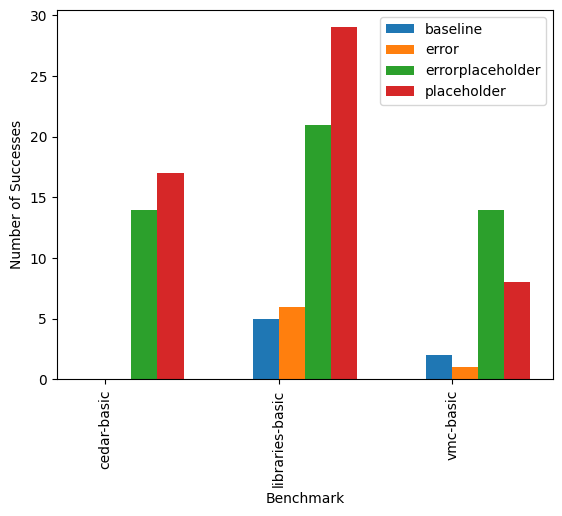

In [ ]:
import numpy as np

# Initialize a dictionary to store the number of successes for each method and benchmark
success_counts = {}

# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Count the number of successes
    # Assuming 'New Method Result' column indicates success if it equals 'Success'
    success_count = int((df["New Method Result"] == "Correct").sum())

    # Add the count to the dictionary
    if benchmark not in success_counts:
        success_counts[benchmark] = {}
    success_counts[benchmark][method] = success_count

# Get a sorted list of benchmarks and methods
benchmarks = sorted(success_counts.keys())
methods = sorted(
    set(method for counts in success_counts.values() for method in counts.keys())
)

bar_width = 0.15
index = np.arange(len(benchmarks))


for i, method in enumerate(methods):
    plt.bar(
        index + i * bar_width,
        [success_counts[benchmark].get(method, 0) for benchmark in benchmarks],
        bar_width,
        label=method,
    )

plt.xlabel("Benchmark")
plt.ylabel("Number of Successes")
plt.xticks(
    index + bar_width / 2, benchmarks, rotation=90
)  # Rotate the x-axis labels for better readability
plt.legend()  # Show legend
plt.show()

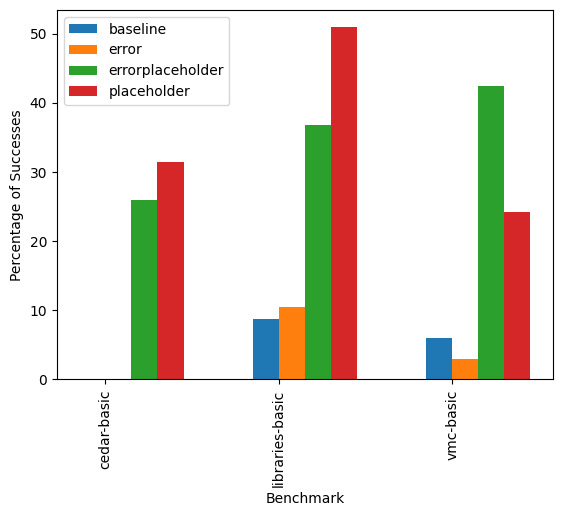

In [ ]:
import numpy as np

# Initialize a dictionary to store the number of successes for each method and benchmark
success_counts = {}
total_counts = {}

# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Count the number of successes
    success_count = int((df["New Method Result"] == "Correct").sum())
    total_count = df["Index"].nunique()  # Count the number of unique indices

    # Add the counts to the dictionaries
    if benchmark not in success_counts:
        success_counts[benchmark] = {}
        total_counts[benchmark] = {}
    success_counts[benchmark][method] = success_count
    total_counts[benchmark][method] = total_count

# Get a sorted list of benchmarks and methods
benchmarks = sorted(success_counts.keys())
methods = sorted(
    set(method for counts in success_counts.values() for method in counts.keys())
)

# Create a grouped bar plot
bar_width = 0.15
index = np.arange(len(benchmarks))

for i, method in enumerate(methods):
    # Calculate the percentage of successes
    percentages = [
        100.0
        * success_counts[benchmark].get(method, 0)
        / total_counts[benchmark].get(method, 1)
        for benchmark in benchmarks
    ]
    plt.bar(index + i * bar_width, percentages, bar_width, label=method)

plt.xlabel("Benchmark")
plt.ylabel("Percentage of Successes")
plt.xticks(
    index + bar_width / 2, benchmarks, rotation=90
)  # Rotate the x-axis labels for better readability
plt.legend()  # Show legend
plt.show()

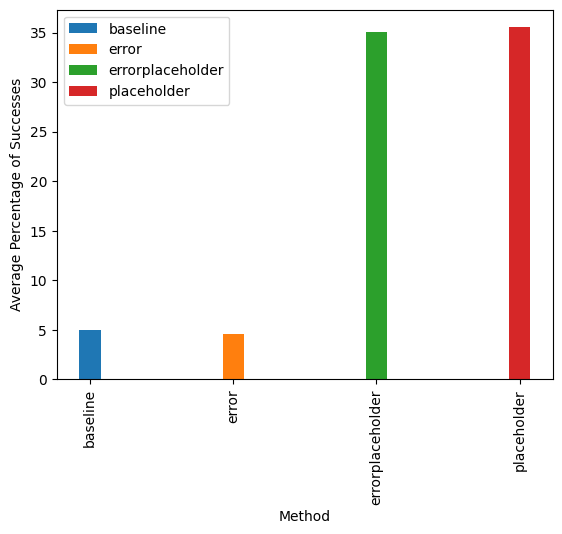

In [ ]:
import numpy as np

# Initialize a dictionary to store the number of successes for each method and benchmark
success_counts = {}
total_counts = {}

# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Count the number of successes
    success_count = int((df["New Method Result"] == "Correct").sum())
    total_count = df["Index"].nunique()  # Count the number of unique indices

    # Add the counts to the dictionaries
    if benchmark not in success_counts:
        success_counts[benchmark] = {}
        total_counts[benchmark] = {}
    success_counts[benchmark][method] = success_count
    total_counts[benchmark][method] = total_count

# Get a sorted list of benchmarks and methods
benchmarks = sorted(success_counts.keys())
methods = sorted(
    set(method for counts in success_counts.values() for method in counts.keys())
)

# Create a grouped bar plot
bar_width = 0.15
index = np.arange(len(methods))

for i, method in enumerate(methods):
    # Calculate the average percentage of successes over the benchmarks
    percentages = [
        100.0
        * success_counts[benchmark].get(method, 0)
        / total_counts[benchmark].get(method, 1)
        for benchmark in benchmarks
    ]
    avg_percentage = sum(percentages) / len(benchmarks)
    plt.bar(index[i], avg_percentage, bar_width, label=method)

plt.xlabel("Method")
plt.ylabel("Average Percentage of Successes")
plt.xticks(
    index, methods, rotation=90
)  # Rotate the x-axis labels for better readability
plt.legend()  # Show legend
plt.show()

## Table of success and failure for each assertion

In [18]:
# Initialize an empty dictionary to store the success and failure methods for each benchmark
methods = {}
methods_non_html = {}

test_results = {
    ("test_lib", "error"): "../results_llm/stats_llm_libraries_sample20_placeholder.csv"
}

# iterate over the test results
for (bench, conf_type), path in test_results.items(): 
    df = pd.read_csv(path)
    results[(bench, conf_type)] = df
# for test, file in test_results.items():
#     df = pd.read_csv(file)
#     results[(test, "test")] = df



# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Group the DataFrame by index
    for index, group in df.groupby("Index"):
        # Check if there's at least one success
        if (group["New Method Result"] == "Correct").any():
            success_method = method
            fail_method = None
        else:
            success_method = None
            fail_method = method

        # Get the URL from the group
        url = group["Url"].iloc[0]  # Assuming all rows in the group have the same URL

        # Add the methods to the dictionary
        if benchmark not in methods:
            methods_non_html[benchmark] = {}
            methods[benchmark] = {}
        if index not in methods[benchmark]:
            methods_non_html[benchmark][index] = {"Success": [], "Fail": []}
            methods[benchmark][index] = {"Success": [], "Fail": []}
        if success_method:
            if success_method == "errorplaceholder":
                success_method = "ep"
            methods_non_html[benchmark][index]["Success"].append(success_method)
            methods[benchmark][index]["Success"].append(
                '<a href="{}">{}</a>'.format(url, success_method)
            )
        if fail_method:
            methods_non_html[benchmark][index]["Fail"].append(fail_method)
            methods[benchmark][index]["Fail"].append(
                '<a href="{}">{}</a>'.format(url, fail_method)
            )

# Convert the dictionary to a DataFrame
df_methods = pd.DataFrame.from_dict(
    {(i, j): methods[i][j] for i in methods.keys() for j in methods[i].keys()},
    orient="index",
)

df_methods_non_html = pd.DataFrame.from_dict(
    {
        (i, j): methods_non_html[i][j]
        for i in methods_non_html.keys()
        for j in methods_non_html[i].keys()
    },
    orient="index",
)

# Convert the DataFrame to HTML and display it
df_methods = df_methods.to_html(escape=False)
display(HTML(df_methods))

In [ ]:
df["New Method Result"].value_counts()

New Method Result
Errors    540
Name: count, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize an array to store the cumulative successes for all indices
successes_data = {}

for (method, benchmark), df in results.items():
    cumulative_successes = [0 * 10]
    # Iterate over the range of tries
    for try_number in range(10):
        # Get the successes for the current try and all previous tries
        successes = df[
            (df["New Method Result"] == "Correct") & (df["Try"] <= try_number)
        ]
        # Count the number of unique indices that were successful
        cumulative_successes.append(successes["Index"].nunique())

    successes_data[(method, benchmark)] = cumulative_successes

In [ ]:
normalized_cumulative_success = {}

for (method, benchmark), cumulative_successes in successes_data.items():
    # Normalize the cumulative successes
    total_indices = results[(method, benchmark)]["Index"].nunique()
    normalized_cumulative_success[(method, benchmark)] = [
        100.0 * successes / total_indices for successes in cumulative_successes
    ]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Group data by benchmark
grouped_data = {}
for (method, benchmark), data in normalized_cumulative_success.items():
    if benchmark not in grouped_data:
        grouped_data[benchmark] = {}
    grouped_data[benchmark][method] = data

{'error+placeholder': 'b', 'placeholder': 'g', 'error': 'r', 'baseline': 'c'}


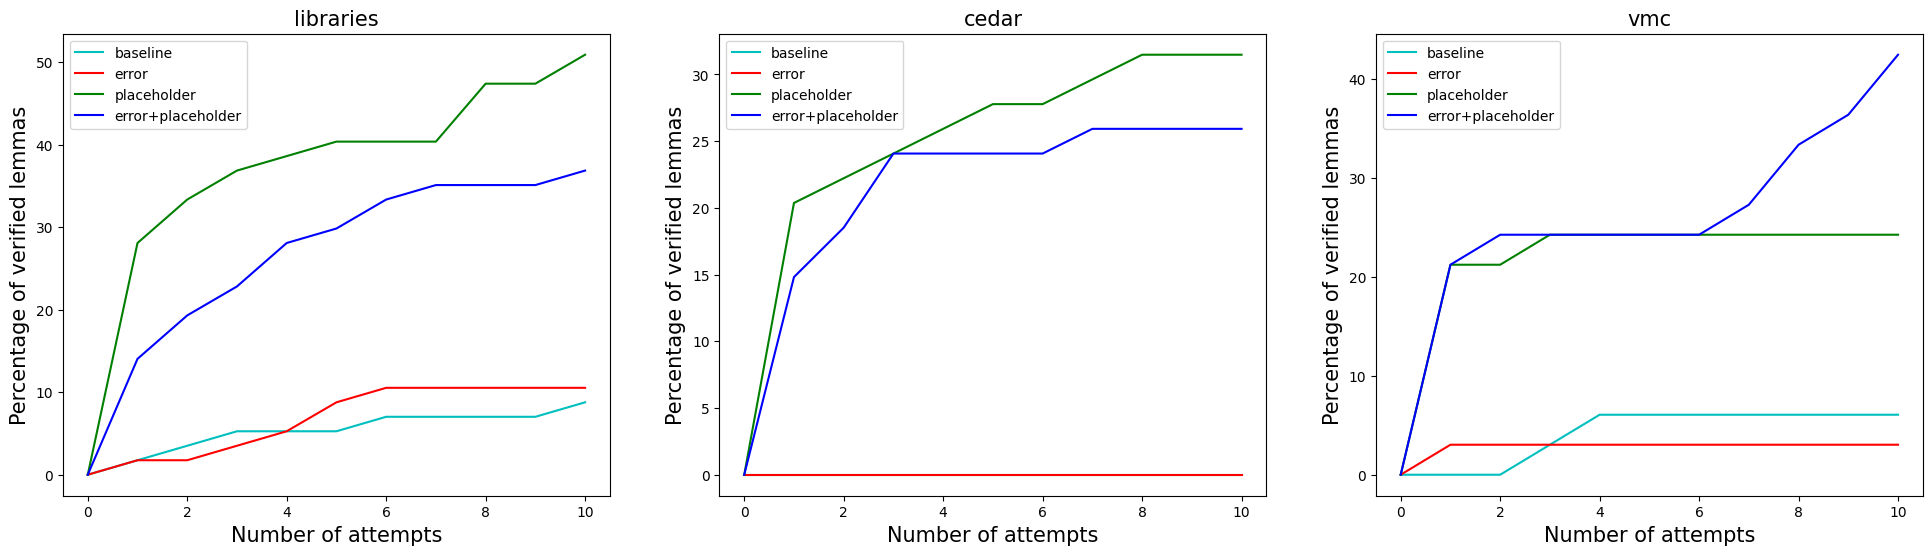

In [ ]:
# Plot data
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
colors = ["b", "g", "r", "c", "m", "y", "k"]
color_map = {
    method: colors[i % len(colors)]
    for i, method in enumerate(
        ["error+placeholder", "placeholder", "error", "baseline"]
    )
}
print(color_map)
i = 0
benchmarks = ["libraries-basic", "cedar-basic", "vmc-basic"]
methods_name = ["baseline", "error", "placeholder", "errorplaceholder"]
for benchmark in benchmarks:
    # axs[i](figsize=(10, 6))
    for method in methods_name:
        method_name = method
        if method == "errorplaceholder":
            method_name = "error+placeholder"
        axs[i].plot(
            grouped_data[benchmark][method],
            label=method_name,
            color=color_map[method_name],
        )
    axs[i].set_title(f"{benchmark[:-6]}", fontsize=15)
    axs[i].set_xlabel("Number of attempts", fontsize=15)
    axs[i].set_ylabel("Percentage of verified lemmas", fontsize=15)
    axs[i].legend(fontsize=10)
    i += 1
plt.savefig("../fig/benchs_placeholder.pdf", bbox_inches="tight")

plt.show()

In [ ]:
for (method, benchmark), data in normalized_cumulative_success.items():
    print(f"final: {method}, {benchmark}: {data[-1]}")

final: placeholder, libraries-basic: 50.87719298245614
final: baseline, libraries-basic: 8.771929824561404
final: error, libraries-basic: 10.526315789473685
final: placeholder, vmc-basic: 24.242424242424242
final: errorplaceholder, cedar-basic: 25.925925925925927
final: errorplaceholder, libraries-basic: 36.8421052631579
final: baseline, vmc-basic: 6.0606060606060606
final: error, vmc-basic: 3.0303030303030303
final: errorplaceholder, vmc-basic: 42.42424242424242
final: error, cedar-basic: 0.0
final: placeholder, cedar-basic: 31.48148148148148
final: baseline, cedar-basic: 0.0


[0.0, 23.217555673696022, 25.589225589225588, 28.38620119321874, 29.58828046547345, 30.790359737728163, 30.790359737728163, 31.407643688345445, 34.36410892551243, 34.36410892551243, 35.53369956878729]
final: placeholder: 35.53369956878729
[0.0, 0.5847953216374269, 1.1695906432748537, 2.764486975013291, 3.774587985114301, 3.774587985114301, 4.359383306751727, 4.359383306751727, 4.359383306751727, 4.359383306751727, 4.944178628389155]
final: baseline: 4.944178628389155
[0.0, 1.594896331738437, 1.594896331738437, 2.1796916533758637, 2.764486975013291, 3.934077618288145, 4.518872939925572, 4.518872939925572, 4.518872939925572, 4.518872939925572, 4.518872939925572]
final: error: 4.518872939925572
[0.0, 16.687341248744758, 20.686396124992616, 23.707838620119322, 25.462224585031603, 26.047019906669032, 27.216610549943884, 29.428790832299608, 31.44899285250163, 32.459093862602636, 35.064091204442086]
final: errorplaceholder: 35.064091204442086


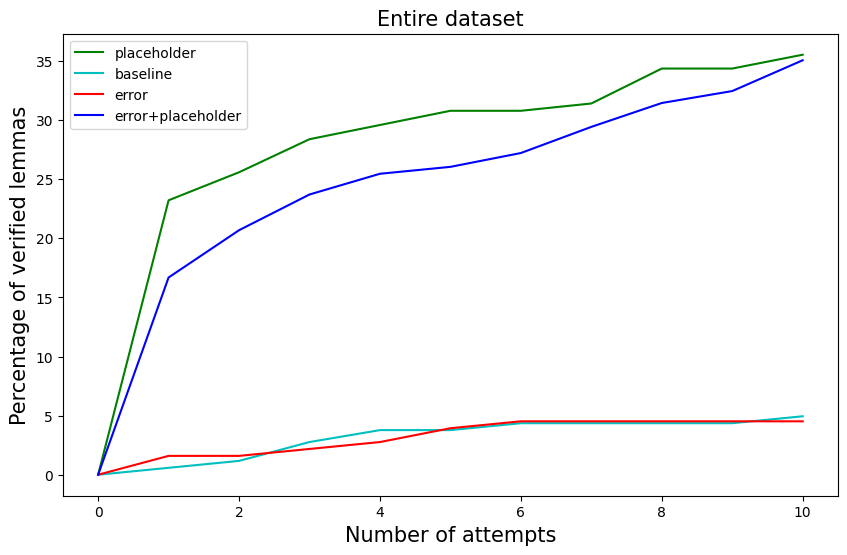

In [ ]:
total_normalized_cumulative_success = {}
for benchmark in grouped_data:
    for method in grouped_data[benchmark]:
        if method not in total_normalized_cumulative_success:
            total_normalized_cumulative_success[method] = [0] * 11
        total_normalized_cumulative_success[method] = [
            x + y
            for x, y in zip(
                total_normalized_cumulative_success[method],
                grouped_data[benchmark][method],
            )
        ]

for method, data in total_normalized_cumulative_success.items():
    total_normalized_cumulative_success[method] = [x / len(grouped_data) for x in data]
    print(total_normalized_cumulative_success[method])
    print(f"final: {method}: {total_normalized_cumulative_success[method][-1]}")

plt.figure(figsize=(10, 6))
for method, data in total_normalized_cumulative_success.items():
    if method == "errorplaceholder":
        method = "error+placeholder"
    plt.plot(data, label=method, color=color_map[method])
    plt.title(f"Entire dataset", fontsize=15)
    plt.xlabel("Number of attempts", fontsize=15)
    plt.ylabel("Percentage of verified lemmas", fontsize=15)
    plt.legend(fontsize=10)
plt.savefig("../fig/entire_dataset_placeholder.pdf", bbox_inches="tight")
plt.show()

In [ ]:
placeholder = set(
    df_methods_non_html[
        df_methods_non_html.apply(
            lambda row: any("placeholder" in sublist for sublist in row["Success"]),
            axis=1,
        )
    ].index
)
errorplaceholder = set(
    df_methods_non_html[
        df_methods_non_html.apply(
            lambda row: any("ep" in sublist for sublist in row["Success"]), axis=1
        )
    ].index
)

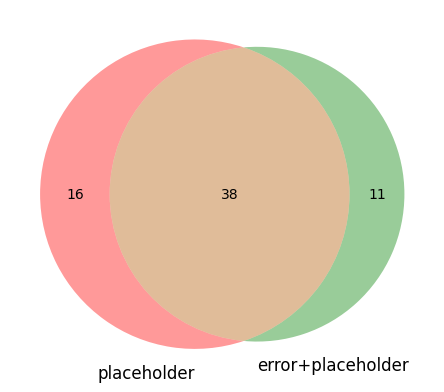

In [ ]:
from matplotlib_venn import venn2, venn3

venn = venn2(
    [placeholder, errorplaceholder],
    set_labels=("placeholder", "error+placeholder", "Both"),
)
plt.savefig("../fig/venn_placeholder.pdf", bbox_inches="tight")
plt.show()